# Librerías

In [2]:
import cdsapi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib as mpl
import glob
import os
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
from pyproj import Proj
import matplotlib.pylab as pl
from scipy import signal
from os.path import dirname, join as pjoin
import scipy.io as sio
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
from netCDF4 import Dataset, num2date
from pytz import timezone
import pytz
import missingno as msno
import re 
import mat73
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


# Personalizar graficas
plt.style.use("default")
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight'] = 'normal'
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)


import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
# Funciones
def proj_ZONE17 (lon, lat):
    """
    Función para cambiar las proyecciones de las coordenadas:
    -----------------------------------------------------------
    Input:
    lon, lat
    ----------------------------------------------------------
    Output:
    UTMX, UTMY
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    UTMx, UTMy = myProj(lon, lat)
    return UTMx,UTMy

def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    ----------------------------------------------------------
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return 360 + lon, lat

def min_ind_rotated_grid (value1, vector1, value2, vector2, delta, view_coords:bool = None):
    """Función para encontrar la mínima diferencia entre dos celdas, usando una grilla de coordenadas 
    X y Y
    ---------------------------------------------------------------------
    Input: 
    - Value1: valor a encontrar de la coordenada x
    - Vector1: vectores donde quiere encontrar dicho valor en la malla X 
    - Value2: valor a encontrar de la coordenada y
    - Vector2: vectores donde quiere encontrar dicho valor en la malla Y 
    - delta: radio para encontrar ese valor 
    - view_coords: Boleano para imprimr las cordenadas reales y en la malla
    ----------------------------------------------------------------------
    Output: 
    - Indi: Indice correpondiente a la fila 
    - Indj: Indice correspondiente a la columna
    """
    indices = np.where(((vector1 > value1-(delta)) & (vector1 < value1+(delta))) & 
                        ((vector2 > value2-(delta)) & (vector2 < value2+(delta))))

    for i, j in zip(indices[0], indices[1]): 
        try :
            if( vector1[i, j] - value1 < vector1[i+1, j+1] - value1) & (vector2[i, j] - value2 < vector2[i+1, j+1] - value2):
                indi = i
                indj = j
            else:
                indi = i+1
                indj = j+1
        except:
            print('************error**********************')
    if view_coords == True:
        print(f'Indices: {indi}, {indj}')
        print(f'Valor 1: {vector1[indi, indj]}, Valor real 1: {value1}' )
        print(f'Valor 2: {vector2[indi, indj]}, Valor real 2: {value2}' )
    return indi, indj

# Grid

In [4]:
def read_grid_file_d3d(num_btw_lines:int, ncols:int, nrows:int, path:str, name_file_grid:str, name_file_deep:str):
    """
    This function read the data from .grd file obtened of d3d
    --------------------------------------------------------------------
    Input:
    - num_btw_lines: cantidad de lineas entre cada eta
    - nrows: numéro de filas del archivo
    - ncols: numéro de columnas del archivo
    - path: ruta del archivo
    - name_file_grid:nombre del archivo
    --------------------------------------------------------------------
    Output: 
    - dic_ : diccionario donde cada llave es una fila y contine 
    las respectivas coordendas que deben ser iguales al numero de columnas 
    """
    patron_eta = r'\b\w+=\s*\d+'
    patron_num =  r'\d+\.\d+E[+-]?\d+'

    with open(f'{path}/{name_file_grid}', 'r') as f:
        contenido = f.read ()
    keys_dic = re.findall(patron_eta, contenido)

    with open(f'{path}/{name_file_grid}', 'r') as f:
        lineas = f.readlines()

    dic_ = {}
    for j, key in enumerate (keys_dic):
        list_ = []
        for i, linea in enumerate(lineas):
            eta = re.findall(patron_eta, linea)
            try:
                if  key == eta[0]:
                    nums_linea = re.findall(patron_num, linea)
                    for nu in nums_linea:
                        list_.append(float(nu))
                    for k in range (1, num_btw_lines):
                        nums_linea_plus = re.findall(patron_num, lineas[i+k])
                        for num in nums_linea_plus:
                            list_.append(float(num))             
            except: 
                pass
        arr= np.array(list_).reshape((ncols-1, 2), order = 'F') 
        dic_.update({key:pd.DataFrame({'X': arr[:,0], 'Y': arr[:,1]})})
    
    patron_num =  r'[-+]?\d+\.\d+E[+-]?\d+'
    with open(f'{path}/{name_file_deep}', 'r') as f:
        contenido = f.read ()
    deep = re.findall(patron_num, contenido)
    Z = []
    for z in deep:
        Z.append(float(z))
    Z = np.array(Z).reshape((nrows, ncols))
    Z[Z<0] = np.nan
    # Z = Z[:-1, :-1]


    X = np.zeros(shape = (nrows-1, ncols-1))
    Y = np.zeros(shape = (nrows-1, ncols-1))
    for i, key in enumerate(list(dic_.keys())):
        X[i, :] = dic_[key]['X']
        Y[i, :] = dic_[key]['Y']

    return X,Y, Z

def read_coast_line (path:str, name_file:str):
    """
    Esta función lee los datos de la linea de costa de un archivo .mat (v6)
    -------------------------------------------------------------------------
    Input:
    - path: ruta del archivo
    - name_file: nombre del archivo
    -------------------------------------------------------------------------
    Output:
    - Data Frame de la linea dosta
    """
    data_dir = pjoin(dirname(sio.__file__), path) # Definir Ruta
    mat_fname = pjoin(data_dir, name_file)     # Econtrar el archivo
    data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
    xlc, ylc = np.array(data_mat['data'][0][0][0]), np.array(data_mat['data'][0][0][1])
    lc  = np.column_stack((xlc,ylc))
    df_lc = pd.DataFrame({'X':lc[:,0], 'Y':lc[:,1] })
    return df_lc

def bat_figure(df_lc:pd.DataFrame, X:np.array, Y:np.array, Z:np.array,delta_lim:float ,delta:float, active_puntos_obs: bool,size:tuple = (7, 5.5), df_ind = None, bottom_legend = None):
    """Función para graficar la malla orientada
    -------------------------------------------------------------------------------------------------
    Input: 
    - df_lc: linea de costa
    - X: arreglo en dos o una dimensión de la malla (dirección x)
    - Y: arreglo en dos o una dimensión de la malla (dirección y)
    - Z: arreglo de las profundidades, las dimesiones deben corresponder con las dimensiones de X y Y
    - size: tupla de las dimensiones de la figura
    - delta: delta para ubicar el norte respecto a la esquina superior derecha (se resta)
    - delta_lim: limites de la figura
    -------------------------------------------------------------------------------------------------
    Output:
    - Figure 

    """

    fig, ax = plt.subplots(figsize = size)
    colormap = cm.Blues
    levels = list(np.round(np.nanmax(Z)*np.array([0,1, 5, 10, 15, 20, 25, 50, 75, 100])/100,0))
    pc = ax.contourf(X, Y, Z,levels = levels,cmap=colormap)
    cb=plt.colorbar(pc)
    a = ax.contour(X, Y, Z,colors="gray",levels=levels,\
                    linewidths=0.2)
    labels = plt.clabel(a, fontsize=8, inline=1, fmt = '%1.0f', colors="gray")
    ax.set_xlabel ('E [m]',size=13, fontweight = 'semibold')
    ax.set_ylabel ('N [m]',size=13, fontweight = 'semibold')
    if (X.min() < df_lc['X'].min()) | (Y.min() < df_lc['Y'].min()):
            ax.set_xlim([X.min() - delta_lim, X.max() + delta_lim])
            ax.set_ylim([Y.min()- delta_lim, Y.max() + delta_lim])
    else:
        ax.set_xlim([df_lc['X'].min(), X.max() + delta_lim])
        ax.set_ylim([df_lc['Y'].min(), Y.max() - delta_lim])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cb.set_label('Depth [m]',size=13, fontweight = 'semibold')
    cb.set_ticklabels(cb.get_ticks(),size=10)
    fig_params(ax)
    fig.suptitle("Bathymetry", size = 13, fontweight = 'semibold')     # Titulo de la figura
    ax.set_title('San Andrés Island',size = 13, fontweight = 'semibold')   # Subtítulo de la figura
    ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
    ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)

    brujula_path, attributes = svg2paths('brujula.svg')
    brujula_marker = parse_path(attributes[0]['d'])
    brujula_marker.vertices -= brujula_marker.vertices.mean(axis=0)
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().rotate_deg(0))
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    ax.scatter(X.max()-delta, Y.max()-delta, marker= brujula_marker, color = 'k', s = 8**3)

    if active_puntos_obs == True:
        colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
        k = 0
        for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
            ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
            k = k+1
        _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
                fancybox=True, shadow=True, ncol=4, fontsize = 9)


    fig.tight_layout()
    plt.xticks(rotation = 20)
    plt.grid(False)



def df_project_grid_grid(n_cols, n_rows, X, Y):
    """
    df_project_grid_grid
    ======================================================================
    ----------------------------------------------------------------------
    Esta función entrega las coordenadas de las fronteras de la batimetría
    ----------------------------------------------------------------------
    Input:
    -----
    - n_cols: número de columnas que se muestran en delft
    - n_rows: número de filas que se muestran en delft
    - X: Arreglo de coordenadas en dirección X 
    - Y: Arreglo de coordenadas en dirección Y
    ----------------------------------------------------------------------
    Output:
    -------
    - df_bat: Dataframe de las coordendas de las fronteras de la malla
    """
    df_bat = pd.concat([pd.DataFrame({'X':X[:,0], 'Y':Y[:,0]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}),
                    pd.DataFrame({'X':X[:,n_cols-2], 'Y':Y[:,n_cols-2]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[0,:], 'Y':Y[0,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[n_rows-2,:], 'Y':Y[n_rows-2,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]})]).reset_index(drop=True)
    
    fun_coords = lambda x: coord_wgs(df_bat.iloc[x,0], df_bat.iloc[x,1])
    coords_bat = list(map(fun_coords, df_bat.index))
    df_bat['lon'] = list(map(lambda x: coords_bat[x][0], df_bat.index))
    df_bat['lat'] = list(map(lambda x: coords_bat[x][1], df_bat.index))

    return df_bat



# Hycom

In [5]:
def read_hycom_data(path, name_file):
    data = Dataset(f'{path}\{name_file}', 'r')
    lat = np.array(data.variables['latitude'][:])
    lon = np.array(data.variables['longitude'][:])
    nctime = np.array(data.variables['time'][:])
    t_unit = data.variables['time'].units
    t_cal = data.variables['time'].calendar
    time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
    time_str = np.array([time[i].strftime("%Y-%m-%d %H:%M:%S") for i in range (len(time))])
    time = np.array([datetime.datetime.strptime(time_str[i], "%Y-%m-%d %H:%M:%S") for i in range (len(time))])
    # Cambiar la zona horaria utc 0 a utc -5
    utc = pytz.utc
    col_zone = timezone('America/Bogota')
    time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
    loc_co =np.array([i.astimezone(col_zone) for i in time2])
    time = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

    salt = np.array(data.variables['salinity'][:])
    salt[salt==-30000] = np.nan
    temp = np.array(data.variables['water_temp'][:])
    temp[temp==-30000] = np.nan
    depth = np.array(data.variables['depth'][:]) 

    dic_ = {'time':time,'lat': lat, 'lon': lon,'depth': depth,  'salt': salt, 'temp': temp }
    return dic_



def min_ind (value, vector, delta):
    """Función para encontrar la mínima diferencia entre dos celdas
    Input: 
    - Value: valor a encontrar 
    - Vector: vectores donde quiere encontrar dicho valor
    - delta: radio para encontrar ese valor 
    ----------------------------------------------------------------------
    Output: 
    - Ind: indices donde mayor se aproxima el valor buscado a los vectores
    """
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if vector[i] - value < vector[i+1] - value:
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)
    return ind



def constituten(c, depth_s, depth_bd, lat_s, lat_bd, lon_s, lon_bd, idate_ini, idate_fin):
    """
    ------------input------------------------
    c: arreglo de la propiedad constitutiva (temp / sal) 
    depth_s: serie de profundidades 
    lat_bd: Cordenanda latitud 
    lon_bd: Coordenada longitud
    lat_s: serie de latitud 
    lon_s: Serie de longitud
    idate_ini: fecha incial de modelación 
    idate_fin: fecha final de la modelación 
    
    ------------output----------------------------
    constituen: serie de la propiedad constitutiva a la profundida deseada
    
    """
    c= c[idate_ini:idate_fin,np.where(depth_s==depth_bd)[0][0], np.where(lat_s==lat_bd)[0][0],np.where(lon_s == lon_bd)[0][0]]
    return c



def time_settings(date_ini, date_fin, time, time_add:bool, date_ini_add: datetime.datetime = None , date_fin_add: datetime.datetime = None):
    """
    Esta función revuelve los mintos y los índicies de la fecha inicial y final del periodo del modelo
    ----------------------------------------------------------------------------------------------------
    Input: 
    - date_ini: fecha inicial del modelo
    - date_fin: fecha final del modelo
    - time: vector de tiempos de la base de datos
    - time_add: si el modelo no incia a las 00:00, active para determinar los minutos desde las 00:00 hasta la hora de incio del modelo
    
    ----------------------------------------------------------------------------------------------------
    Output: 
    - ind_ini_fin: indices de la fecha inicial y final que coincieden con los tiempos de la base de datos 
    - minutes: minutos contados a partir de la fecha incial 
    """
    ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
    time_d3d = time[ind_ini_fin[0]:ind_ini_fin[1]]
    minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])

    if time_add == True:        
        minutes_add = (date_fin_add- date_ini_add).seconds/60
        minutes = minutes + minutes_add
    return ind_ini_fin, minutes

In [6]:
def plot_cells_data_base (lon:np.array, lat:np.array, plot_dfbat:bool, df_bat: pd.DataFrame = None):
    """
    Esta función plotea los centros de las celdas donde hay información de la base de datos
    -----------------------------------------------------------------------------------------
    Input:
    ------
    - lon: arreglo de las longitudes de los datos obtenidos de la base de datos
    - lat:  arreglo de las latitudes de los datos obtenidos de la base de datos
    - plot_df_bat: True/ False: para plotear o no la ubicación de la malla con respecto a la base de datos 
    ------------------------------------------------------------------------------------------------------
    Output: 
    -------
    - Figure
    """ 

    fig = plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
    ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.stock_img()
    ax1.add_feature(cf.LAND, zorder= 10)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
    # ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


    colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
    i = 0
    for loni in (lon):
        for lati in (lat):
            ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
            i = i +1

    if plot_dfbat == True: 
        ax1.scatter(df_bat['lon'], df_bat['lat'],color = 'red', s=1)
    ax1.set_yticklabels(ax1.get_yticks() , color='gray',size = 12)
    ax1.set_xticklabels(ax1.get_xticks() , color='gray',size = 12)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')




    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' }
    gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold' }


    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')

    # _= fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.9),
    #           fancybox=True, shadow=True, ncol=2, fontsize = 8,prop=prop2, labelcolor = 'gray')
    fig.suptitle('Localización de los pixeles',size=12);
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.25)

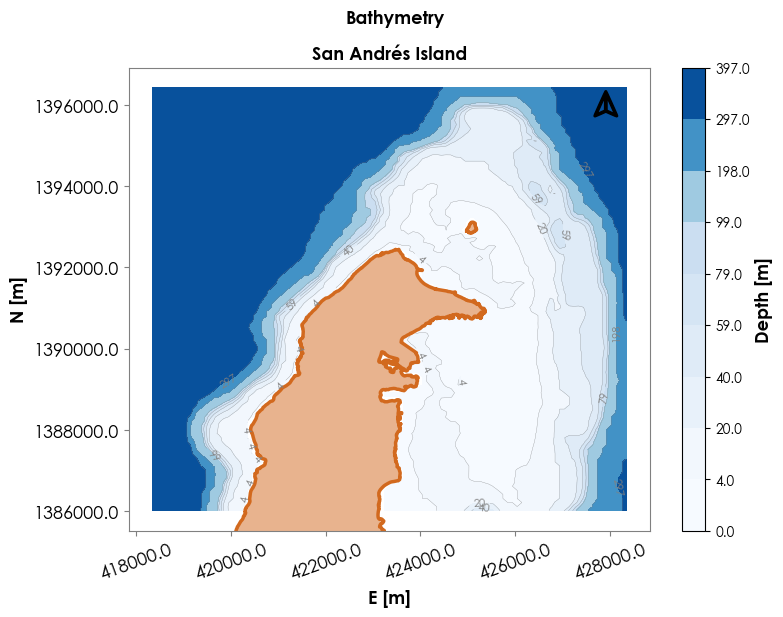

In [8]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_NORTE_RECTANGULAR_100m'
# path = r'C:\Users\paula\Desktop\BAT_SAI_NORTE_3D_V2'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'

# num_lineas = 31
# n_rows = 238 #83
# n_cols = 155

num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line (path= path, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,size = (8, 6), active_puntos_obs = False)

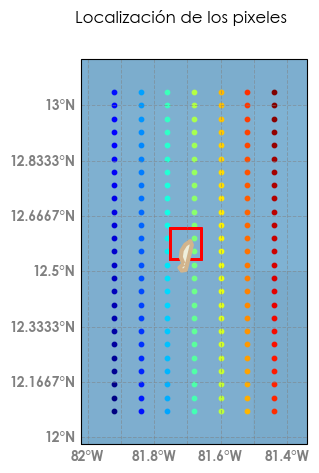

In [9]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS'
name_file = 'Hycom_oct21_nov15_2021_6_temp_sal_2.nc'
dic_prop = read_hycom_data(path, name_file)
lat = dic_prop['lat']
lon = dic_prop['lon']
plot_cells_data_base (lon = lon, lat = lat, plot_dfbat = True, df_bat = df_bat_sai)

In [8]:
# Time split
date_ini = datetime.datetime(2021,11,1,1,0) # Fechas inicial de modelación
date_fin = datetime.datetime(2021,11,14,19,0) # Fechas final de modelación

date_ini_add = datetime.datetime(2021,11,1,1,0)
date_fin_add = date_ini
ind_ini_fin, minutes = time_settings(date_ini = date_ini , date_fin = date_fin , time = dic_prop['time'], 
                                     time_add= False, date_ini_add = date_ini_add , date_fin_add = date_fin_add)


n_capas = int(input('Ingrese el numero de capas a modelar',))
grid_type = str(input('Ingrese el tipo de malla (s: sigma, z: zeta)',))
if n_capas == 1: 
    grid_type = 's'

if grid_type == 's':
    depth_layer = list([dic_prop['depth'][:n_capas]][0])
elif grid_type=='z':
    depth_layer = list([dic_prop['depth'][:n_capas]][0])[::-1]

print(depth_layer)

path_bnd = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CALIBRACION\MODEL_SAI_NORTE_GRID2_RECTANGULAR\BAT_SAI_GRID_2_NORTE_V1'
name_file = 'TEST_X_BND.bnd'
df_bnd = pd.read_csv(f'{path_bnd}\{name_file}', sep= '\s+', usecols=[0,3,4,5,6], names=['Frontera', 'McolA', 'NrowA', 'McolB', 'NrowB'])

[0.0]


Indice: 3 , Valor: 278.32000732421875 , Valor real: [278.24809027]
Indice: 14 , Valor: 12.640000343322754 , Valor real: [12.63069642]
Indice: 4 , Valor: 278.4000244140625 , Valor real: [278.33924401]
Indice: 14 , Valor: 12.640000343322754 , Valor real: [12.63093775]


<AxesSubplot:>

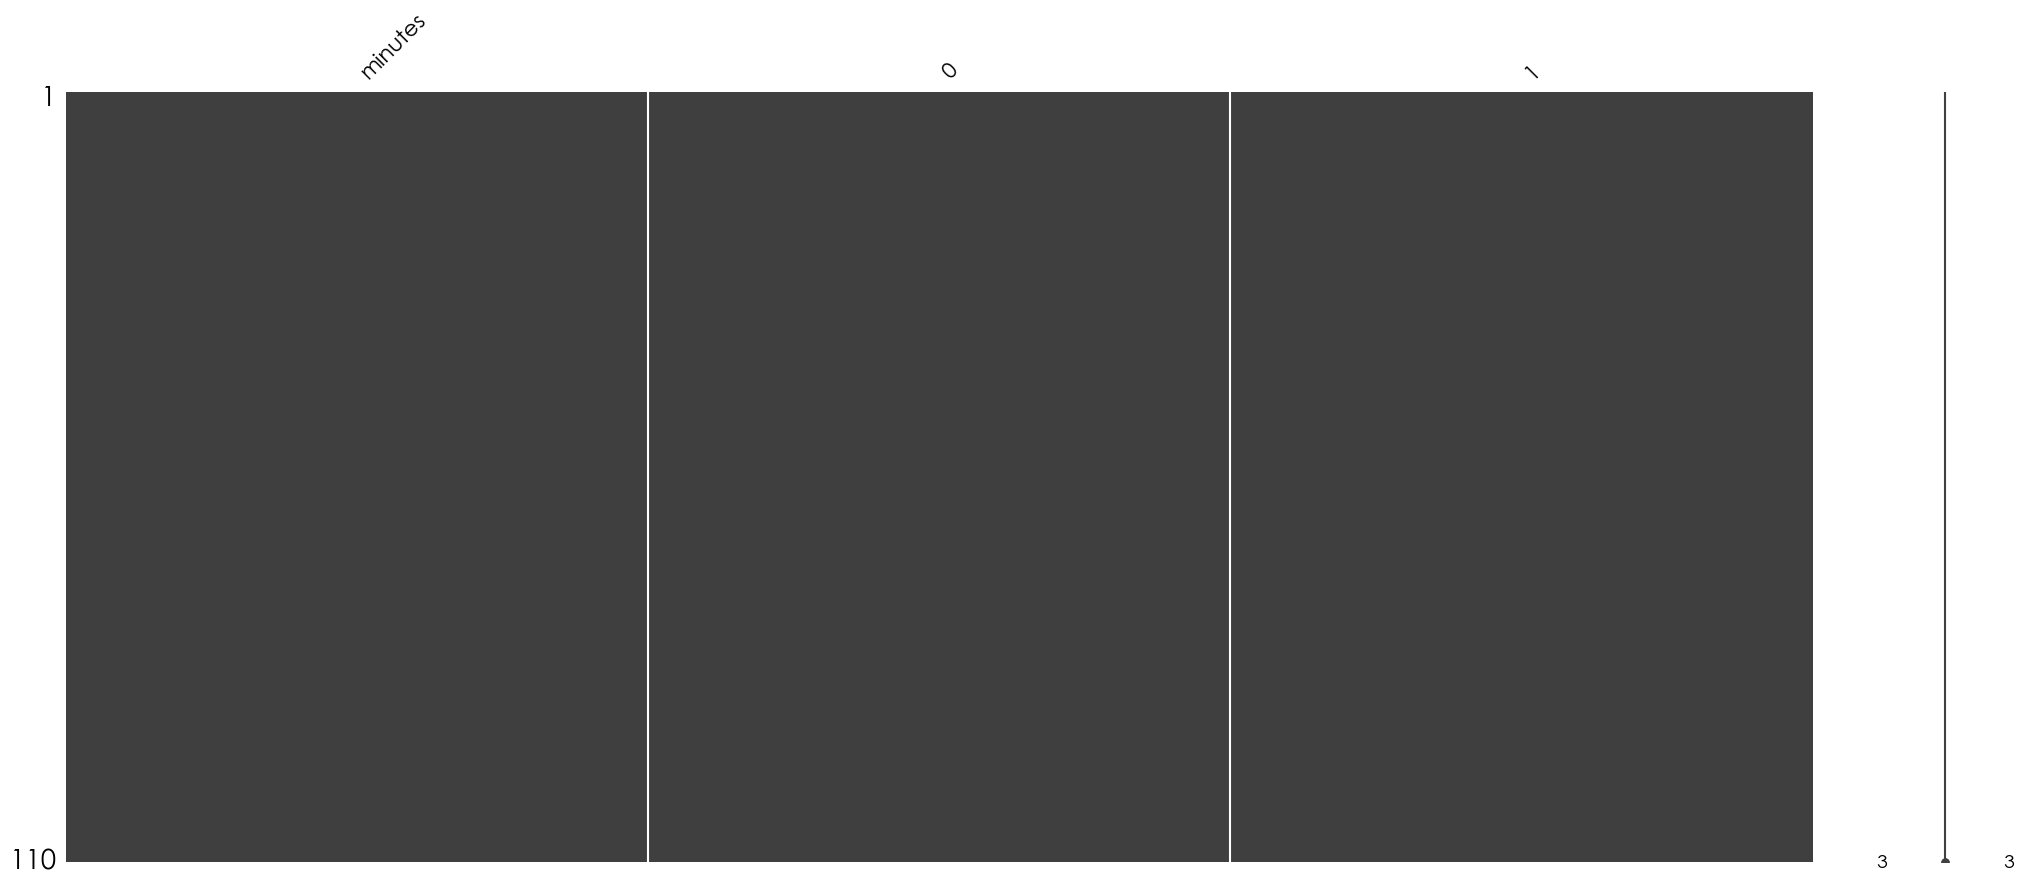

In [9]:
# __________________________Frontera más al norte________________________________________________________
frontera = 'Norte'
iNrowA =  df_bnd[df_bnd['Frontera']==frontera].NrowA
iMcolA = df_bnd[df_bnd['Frontera']==frontera].McolA
Px_bd1_A, Py_bd1_A = X[iNrowA- 2, iMcolA- 2], Y[iNrowA- 2, iMcolA- 2]
lon_bd1_A, lat_bd1_A = coord_wgs(Px_bd1_A, Py_bd1_A)
ilon_bd1_A = min_ind(value=lon_bd1_A, vector=dic_prop['lon'], delta=0.08)
ilat_bd1_A = min_ind(value=lat_bd1_A, vector=dic_prop['lat'], delta=0.04)

iNrowB =  df_bnd[df_bnd['Frontera']==frontera].NrowB
iMcolB = df_bnd[df_bnd['Frontera']==frontera].McolB
Px_bd1_B, Py_bd1_B = X[iNrowB- 2, iMcolB- 2], Y[iNrowB- 2, iMcolB- 2]
lon_bd1_B, lat_bd1_B = coord_wgs(Px_bd1_B, Py_bd1_B) 
ilon_bd1_B = min_ind(value=lon_bd1_B, vector=dic_prop['lon'], delta=0.08)
ilat_bd1_B = min_ind(value=lat_bd1_B, vector=dic_prop['lat'], delta=0.04) 

dic_salt = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd1_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd1_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd1_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd1_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({n_capas + j:c})

df_salt = pd.DataFrame(dic_salt)
df_salt.insert(loc= 0, column = 'minutes', value = minutes)
# df_salt[0] = df_salt[1]-0.1
msno.matrix(df_salt)

In [10]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = f'salt_{frontera}_VALIDACION.bcc'
np.savetxt(path+'/'+name_file, df_salt.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

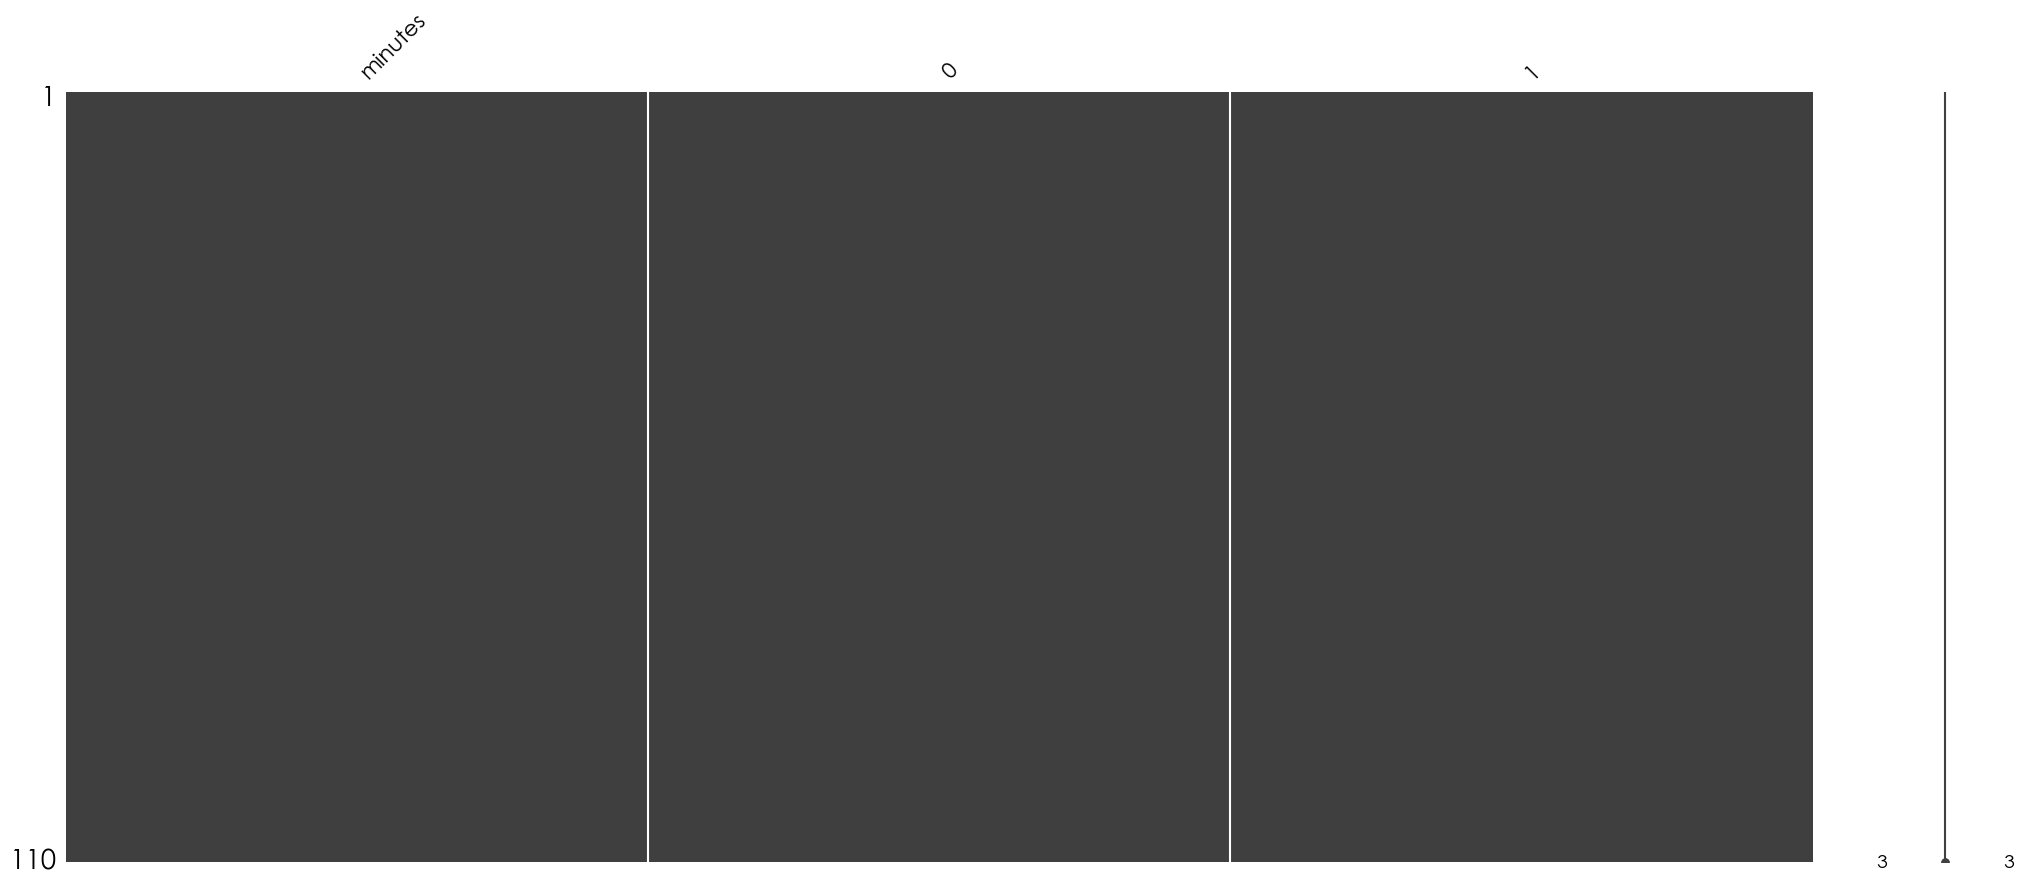

In [11]:
dic_temp = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd1_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd1_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd1_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd1_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({n_capas + j:c})

df_temp = pd.DataFrame(dic_temp)
df_temp.insert(loc= 0, column = 'minutes', value = minutes)
# df_temp[0] = df_temp[1]-1
msno.matrix(df_temp)

In [12]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = f'temp_{frontera}_VALIDACION.bcc'
np.savetxt(path+'/'+name_file, df_temp.values, delimiter=' ', fmt = "%+15.7e")

Indice: 3 , Valor: 278.32000732421875 , Valor real: [278.24809027]
Indice: 14 , Valor: 12.640000343322754 , Valor real: [12.63069642]
Indice: 3 , Valor: 278.32000732421875 , Valor real: [278.26466354]
Indice: 14 , Valor: 12.640000343322754 , Valor real: [12.63074262]


<AxesSubplot:>

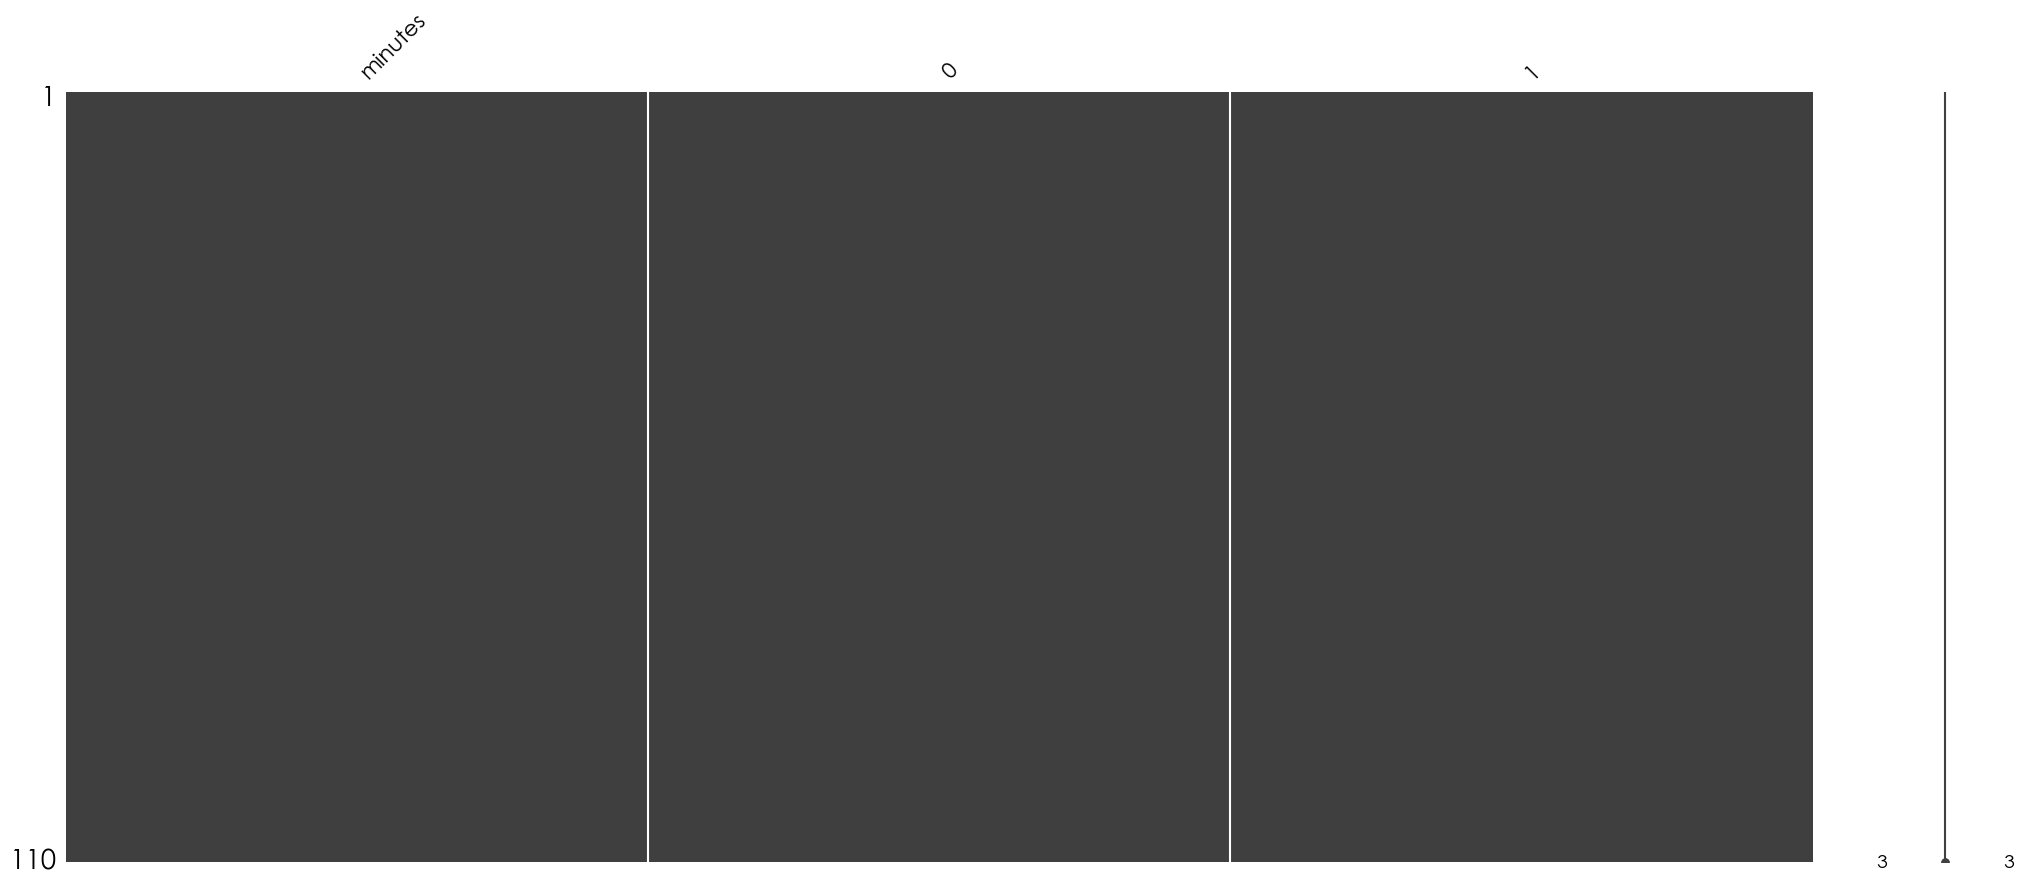

In [13]:
#_______________________Frontera más al SUROESTE_________________________________________

frontera = 'Suroeste'
iNrowA =  df_bnd[df_bnd['Frontera']==frontera].NrowA
iMcolA = df_bnd[df_bnd['Frontera']==frontera].McolA
Px_bd2_A, Py_bd2_A = X[iNrowA- 2, iMcolA- 2], Y[iNrowA- 2, iMcolA- 2]
lon_bd2_A, lat_bd2_A = coord_wgs(Px_bd2_A, Py_bd2_A)
ilon_bd2_A = min_ind(value=lon_bd2_A, vector=dic_prop['lon'], delta=0.08)
ilat_bd2_A = min_ind(value=lat_bd2_A, vector=dic_prop['lat'], delta=0.04)
 
iNrowB =  df_bnd[df_bnd['Frontera']==frontera].NrowB
iMcolB = df_bnd[df_bnd['Frontera']==frontera].McolB
Px_bd2_B, Py_bd2_B = X[iNrowB- 2, iMcolB- 2], Y[iNrowB- 2, iMcolB- 2]
lon_bd2_B, lat_bd2_B = coord_wgs(Px_bd2_B, Py_bd2_B)
ilon_bd2_B = min_ind(value=lon_bd2_B, vector=dic_prop['lon'], delta=0.08)
ilat_bd2_B = min_ind(value=lat_bd2_B, vector=dic_prop['lat'], delta=0.04) 


dic_salt = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd2_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd2_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd2_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd2_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({n_capas + j:c})

df_salt = pd.DataFrame(dic_salt)
df_salt.insert(loc= 0, column = 'minutes', value = minutes)
msno.matrix(df_salt)

In [14]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = f'salt_{frontera}_VALIDACION.bcc'
np.savetxt(path+'/'+name_file, df_salt.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

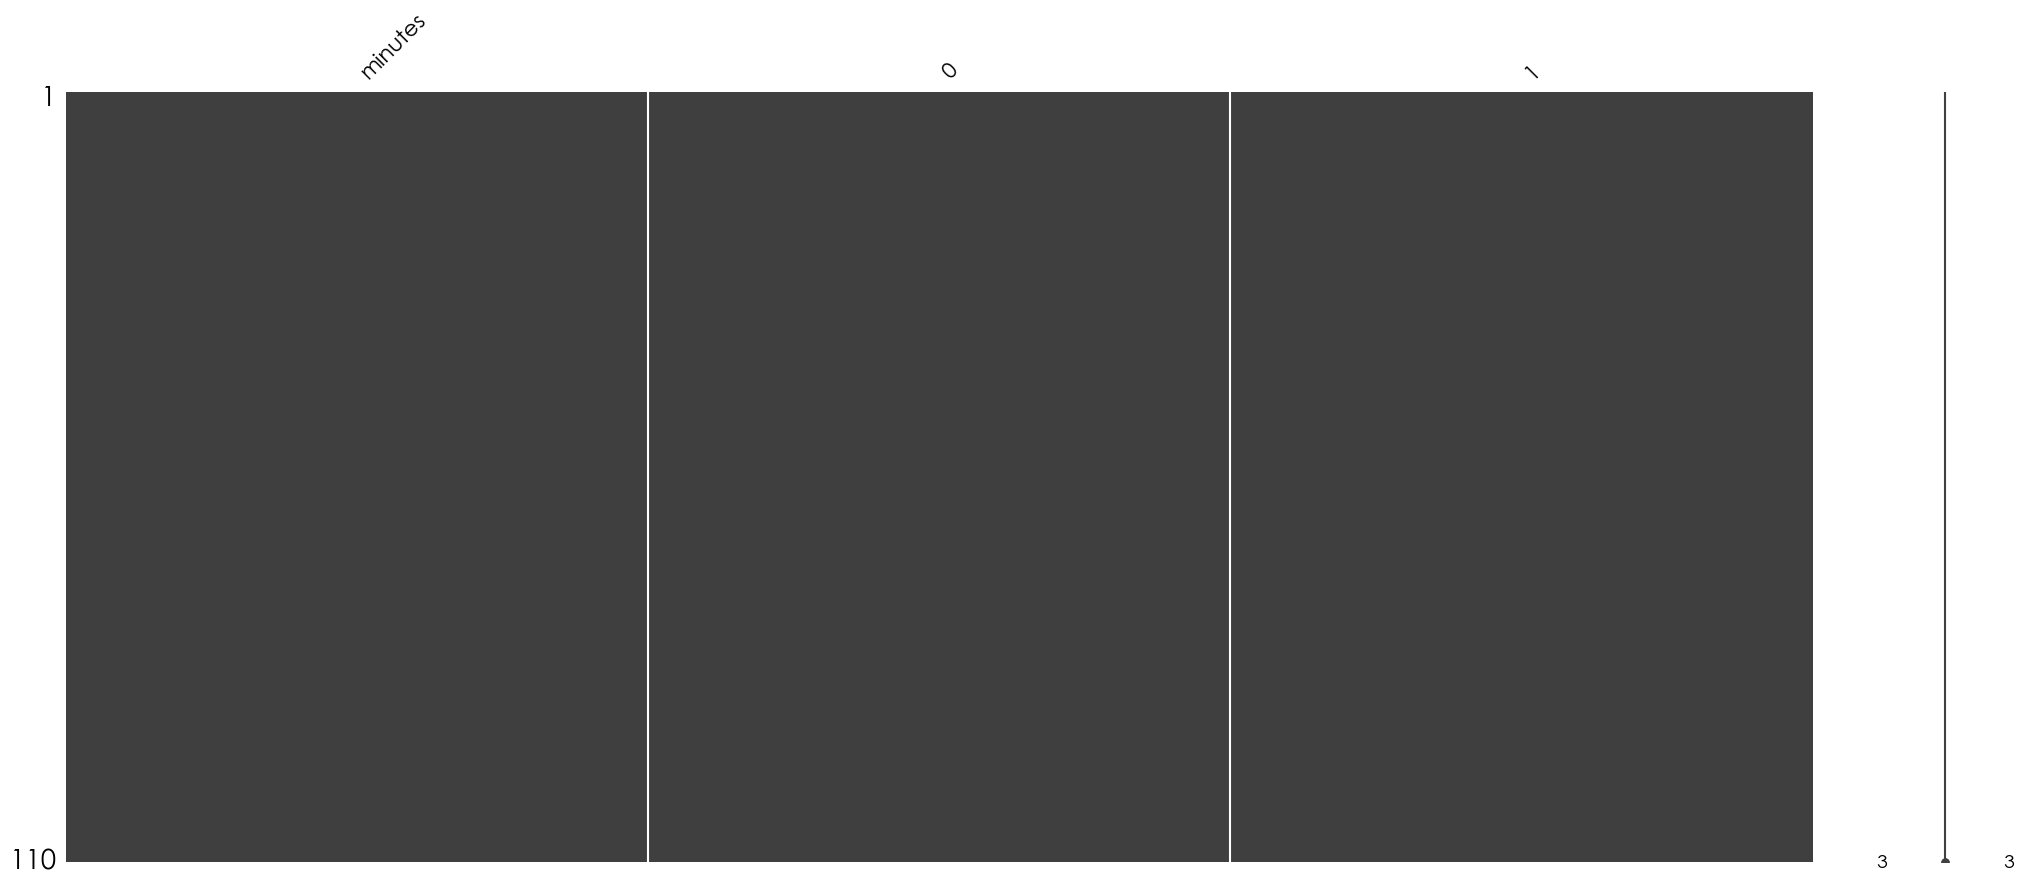

In [15]:
dic_temp = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd2_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd2_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd2_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd2_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({n_capas + j:c})

df_temp = pd.DataFrame(dic_temp)
df_temp.insert(loc= 0, column = 'minutes', value = minutes)
# # df_temp[18] = df_temp[19] -1
# df_temp[17] = df_temp[18] -1
# # df_temp[1] = df_temp[2] -1
# df_temp[0] = df_temp[1] -1
msno.matrix(df_temp)

In [16]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = f'temp_{frontera}_VALIDACION.bcc'
np.savetxt(path+'/'+name_file, df_temp.values, delimiter=' ', fmt = "%+15.7e")

Indice: 3 , Valor: 278.32000732421875 , Valor real: [278.29228579]
Indice: 14 , Valor: 12.640000343322754 , Valor real: [12.63081732]
Indice: 4 , Valor: 278.4000244140625 , Valor real: [278.33924401]
Indice: 14 , Valor: 12.640000343322754 , Valor real: [12.63093775]


<AxesSubplot:>

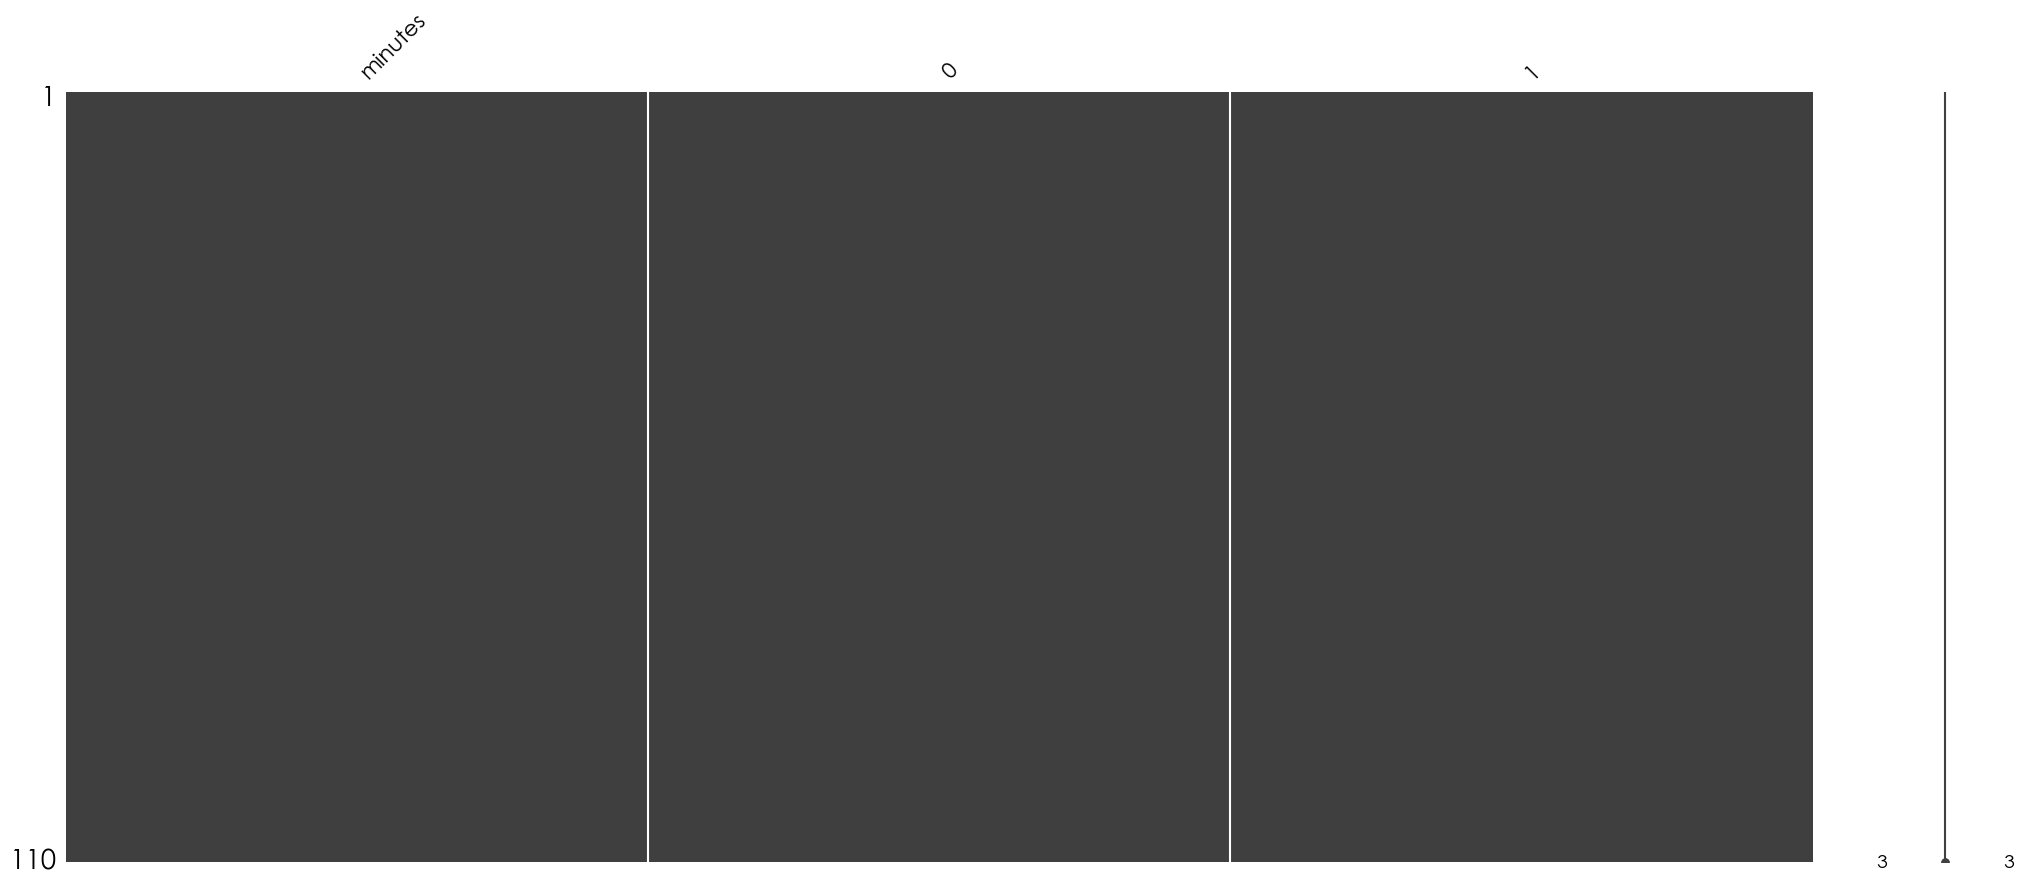

In [17]:
#_______________________Frontera más al SURESTE_________________________________________

frontera = 'Sureste'
iNrowA =  df_bnd[df_bnd['Frontera']==frontera].NrowA
iMcolA = df_bnd[df_bnd['Frontera']==frontera].McolA
Px_bd3_A, Py_bd3_A = X[iNrowA- 2, iMcolA- 2], Y[iNrowA- 2, iMcolA- 2]
lon_bd3_A, lat_bd3_A = coord_wgs(Px_bd3_A, Py_bd3_A)
ilon_bd3_A = min_ind(value=lon_bd3_A, vector=dic_prop['lon'], delta=0.08)
ilat_bd3_A = min_ind(value=lat_bd3_A, vector=dic_prop['lat'], delta=0.04)
 
iNrowB =  df_bnd[df_bnd['Frontera']==frontera].NrowB
iMcolB = df_bnd[df_bnd['Frontera']==frontera].McolB
Px_bd3_B, Py_bd3_B = X[iNrowB- 2, iMcolB- 2], Y[iNrowB- 2, iMcolB- 2]
lon_bd3_B, lat_bd3_B = coord_wgs(Px_bd3_B, Py_bd3_B)
ilon_bd3_B = min_ind(value=lon_bd3_B, vector=dic_prop['lon'], delta=0.08)
ilat_bd3_B = min_ind(value=lat_bd3_B, vector=dic_prop['lat'], delta=0.04) 


dic_salt = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd3_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd3_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd3_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd3_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({n_capas + j:c})

df_salt = pd.DataFrame(dic_salt)
df_salt.insert(loc= 0, column = 'minutes', value = minutes)
msno.matrix(df_salt)

In [18]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = f'salt_{frontera}_VALIDACION.bcc'
np.savetxt(path+'/'+name_file, df_salt.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

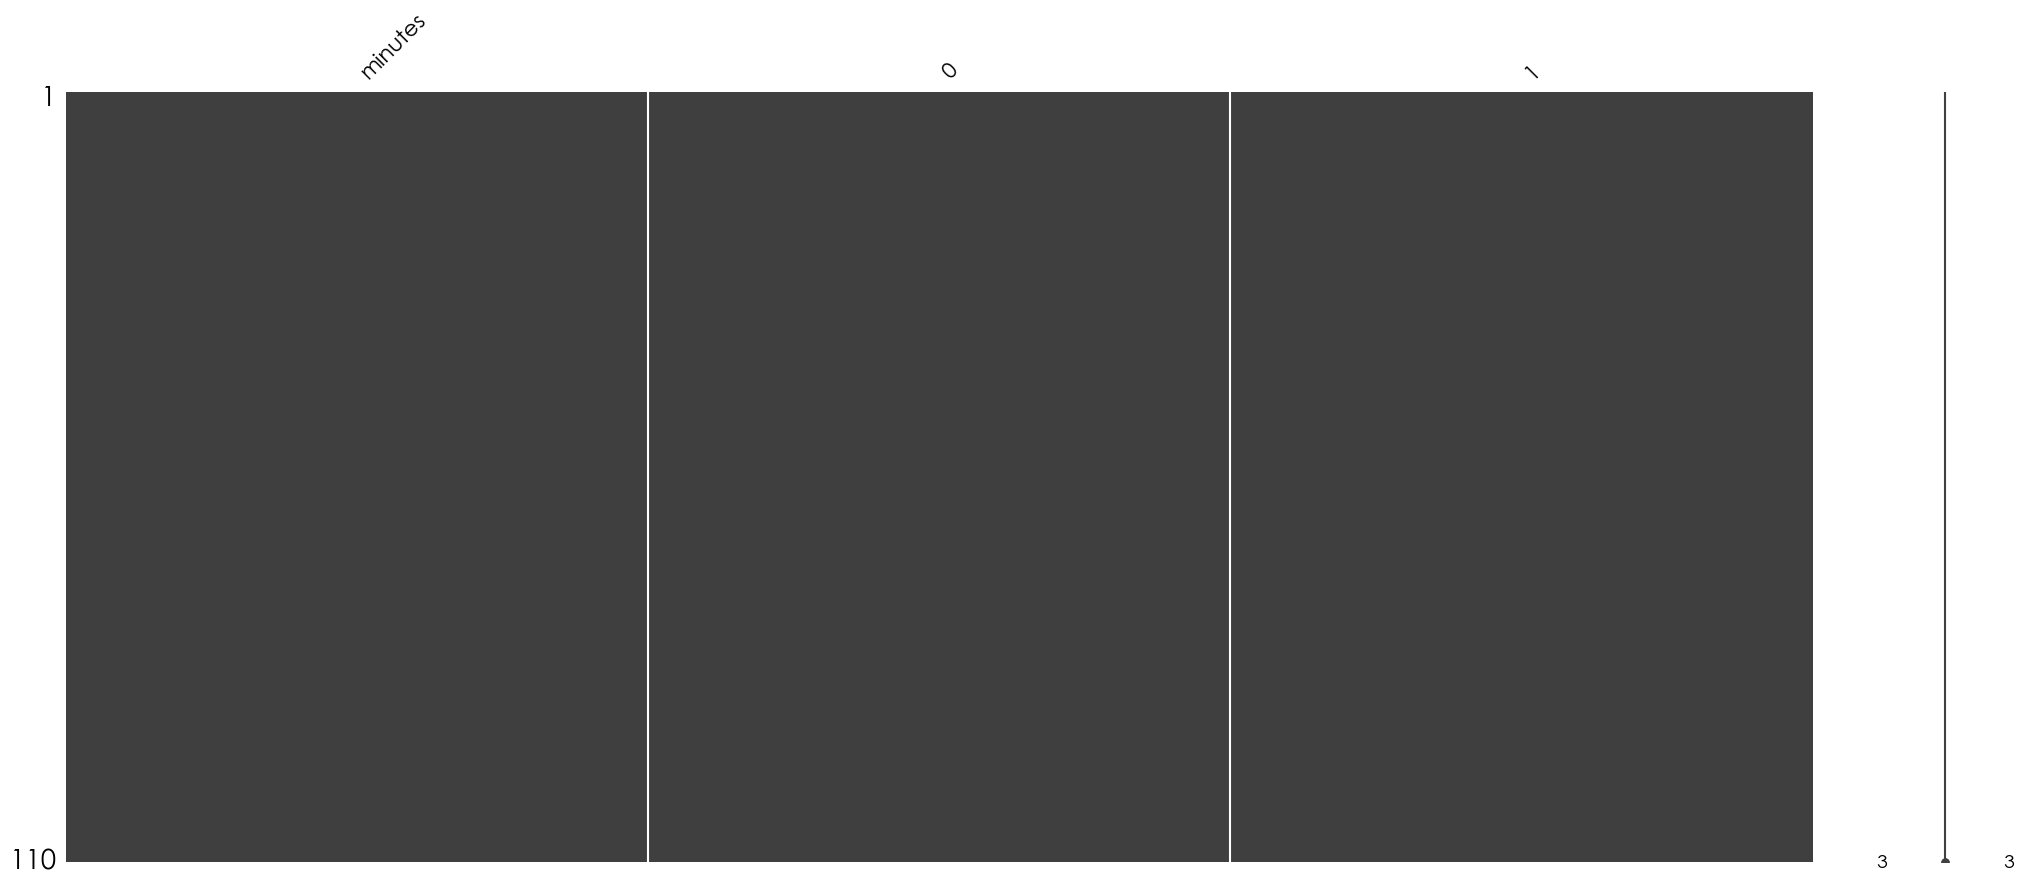

In [19]:
dic_temp = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd3_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd3_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd3_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd3_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({n_capas + j:c})

df_temp = pd.DataFrame(dic_temp)
df_temp.insert(loc= 0, column = 'minutes', value = minutes)
# # df_temp[18] = df_temp[19] -1
# df_temp[17] = df_temp[18] -1
# # df_temp[1] = df_temp[2] -1
# df_temp[0] = df_temp[1] -1
msno.matrix(df_temp)

In [20]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = f'temp_{frontera}_VALIDACION.bcc'
np.savetxt(path+'/'+name_file, df_temp.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

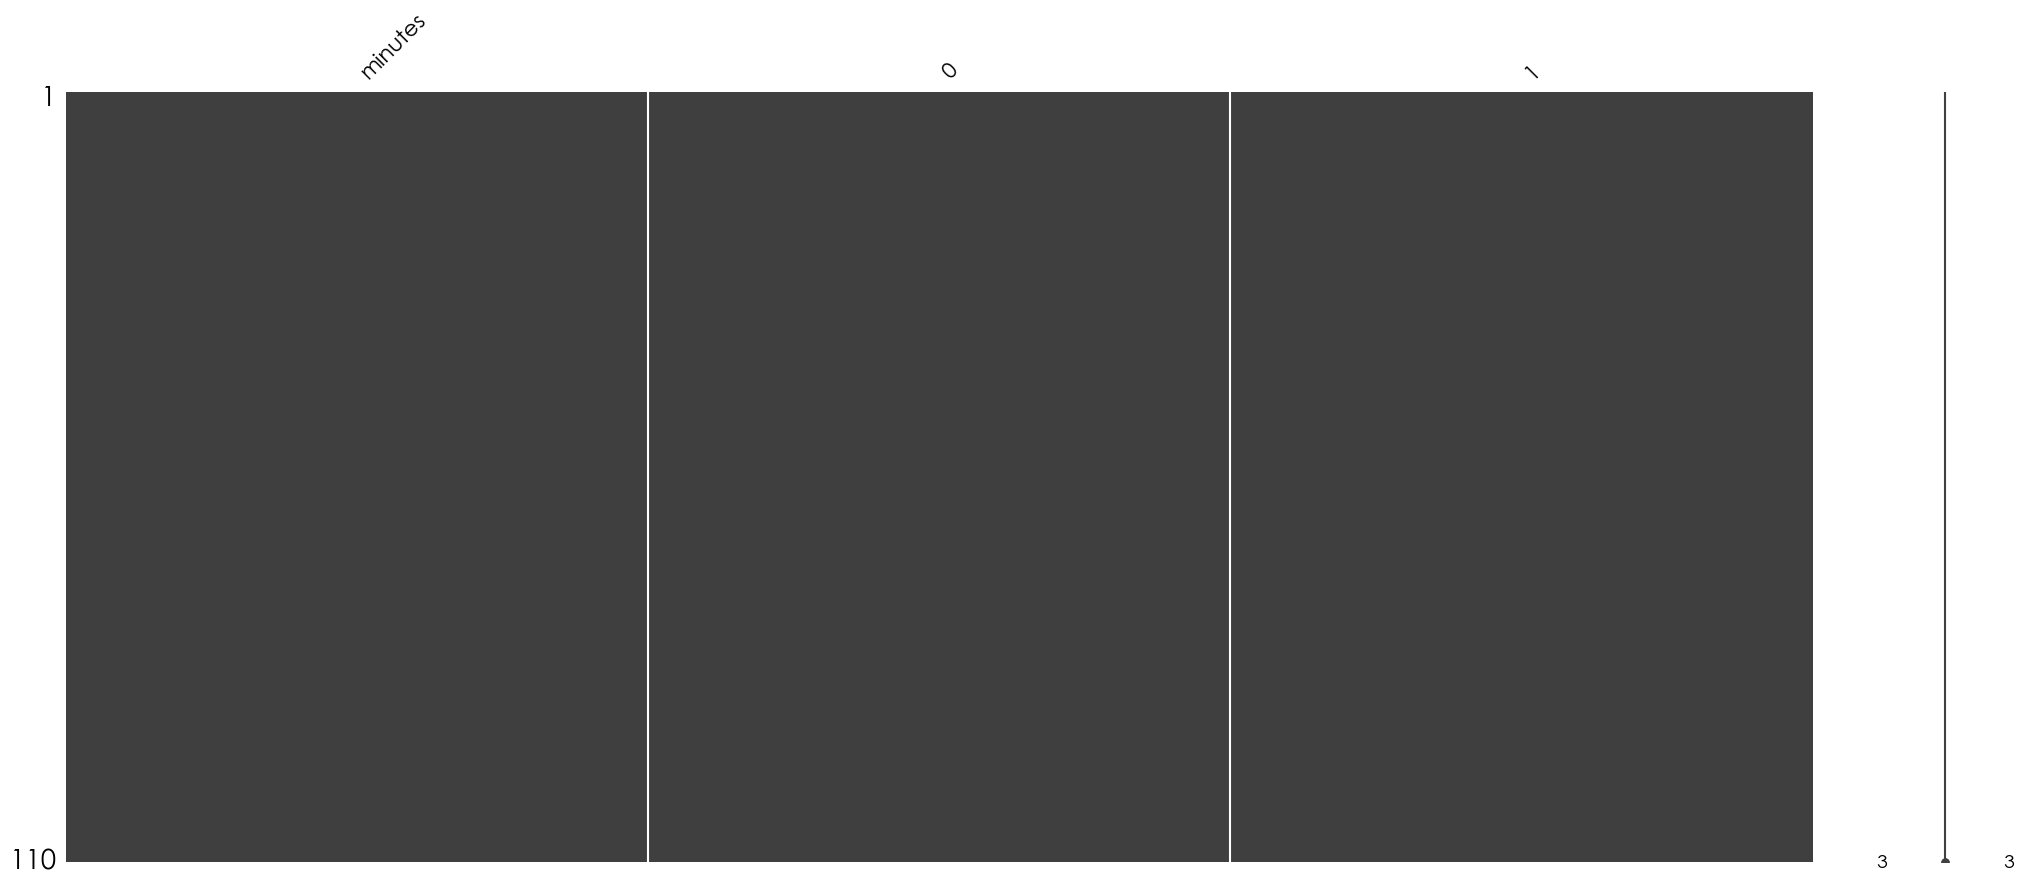

In [21]:
#_______________________Frontera más al ESTE_________________________________________

frontera = 'Este'
# más OESTE
ilat_bd4_A = ilat_bd3_B # Sureste B
ilon_bd4_A = ilon_bd3_B # Sureste B

ilat_bd4_B = ilat_bd1_B # Norte B
ilon_bd4_B = ilon_bd1_B # Norte B
dic_salt = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd4_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd4_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd4_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd4_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({n_capas + j:c})

df_salt = pd.DataFrame(dic_salt)
df_salt.insert(loc= 0, column = 'minutes', value = minutes)
# df_salt[17] = df_salt[18] -0.1
# df_salt[1] = df_salt[2] -0.1
# df_salt[0] = df_salt[1] -0.1
msno.matrix(df_salt)

In [22]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = f'salt_{frontera}_VALIDACION.bcc'
np.savetxt(path+'/'+name_file, df_salt.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

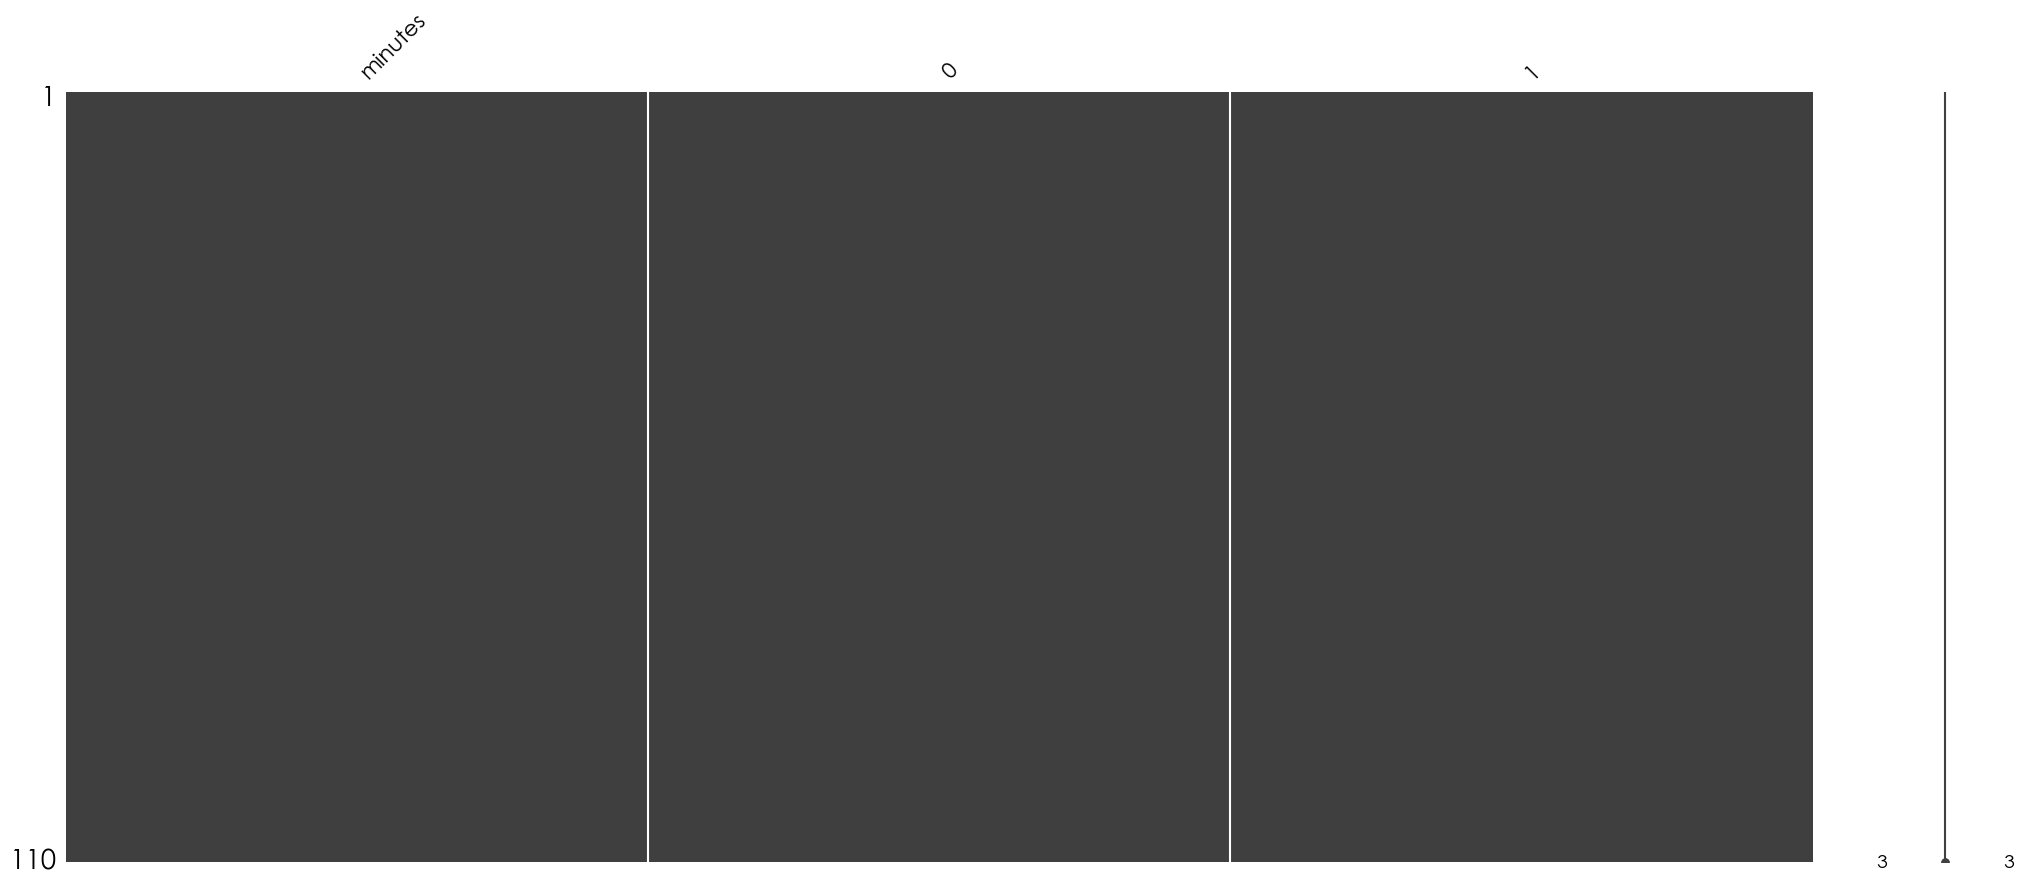

In [23]:
dic_temp = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd4_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd4_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd4_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd4_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({n_capas + j:c})

df_temp = pd.DataFrame(dic_temp)
df_temp.insert(loc= 0, column = 'minutes', value = minutes)
# df_temp[17] = df_temp[18] - 1
# df_temp[1] = df_temp[2] - 1
# df_temp[0] = df_temp[1] - 1
msno.matrix(df_temp)

In [24]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = f'temp_{frontera}_VALIDACION.bcc'
np.savetxt(path+'/'+name_file, df_temp.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

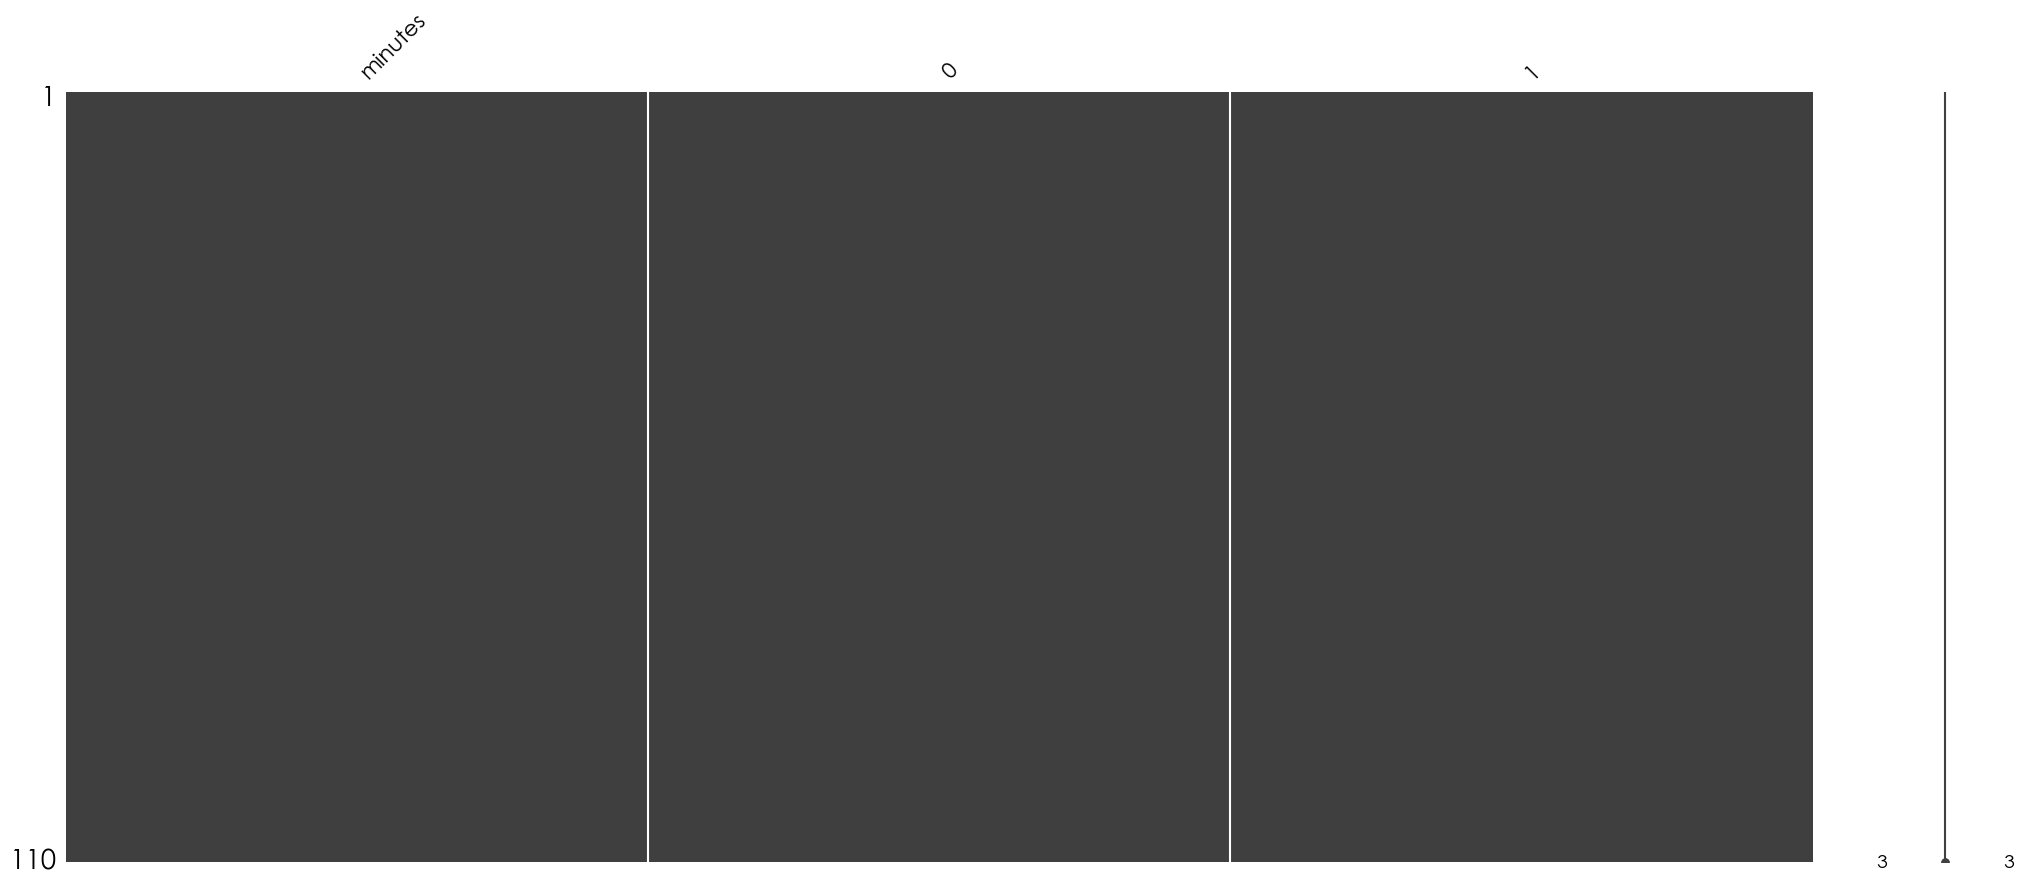

In [25]:
#_______________________Frontera más al OESTE_________________________________________

frontera = 'Oeste'
# más OESTE
ilat_bd5_A = ilat_bd2_A # Suroeste A
ilon_bd5_A = ilon_bd2_A # Suroeste A

ilat_bd5_B = ilat_bd1_A # Norte A
ilon_bd5_B = ilon_bd1_A # Norte A
dic_salt = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd5_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd5_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd5_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd5_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({n_capas + j:c})

df_salt = pd.DataFrame(dic_salt)
df_salt.insert(loc= 0, column = 'minutes', value = minutes)
# df_salt[17] = df_salt[18] -0.1
# df_salt[1] = df_salt[2] -0.1
# df_salt[0] = df_salt[1] -0.1
msno.matrix(df_salt)

In [26]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = f'salt_{frontera}_VALIDACION.bcc'
np.savetxt(path+'/'+name_file, df_salt.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

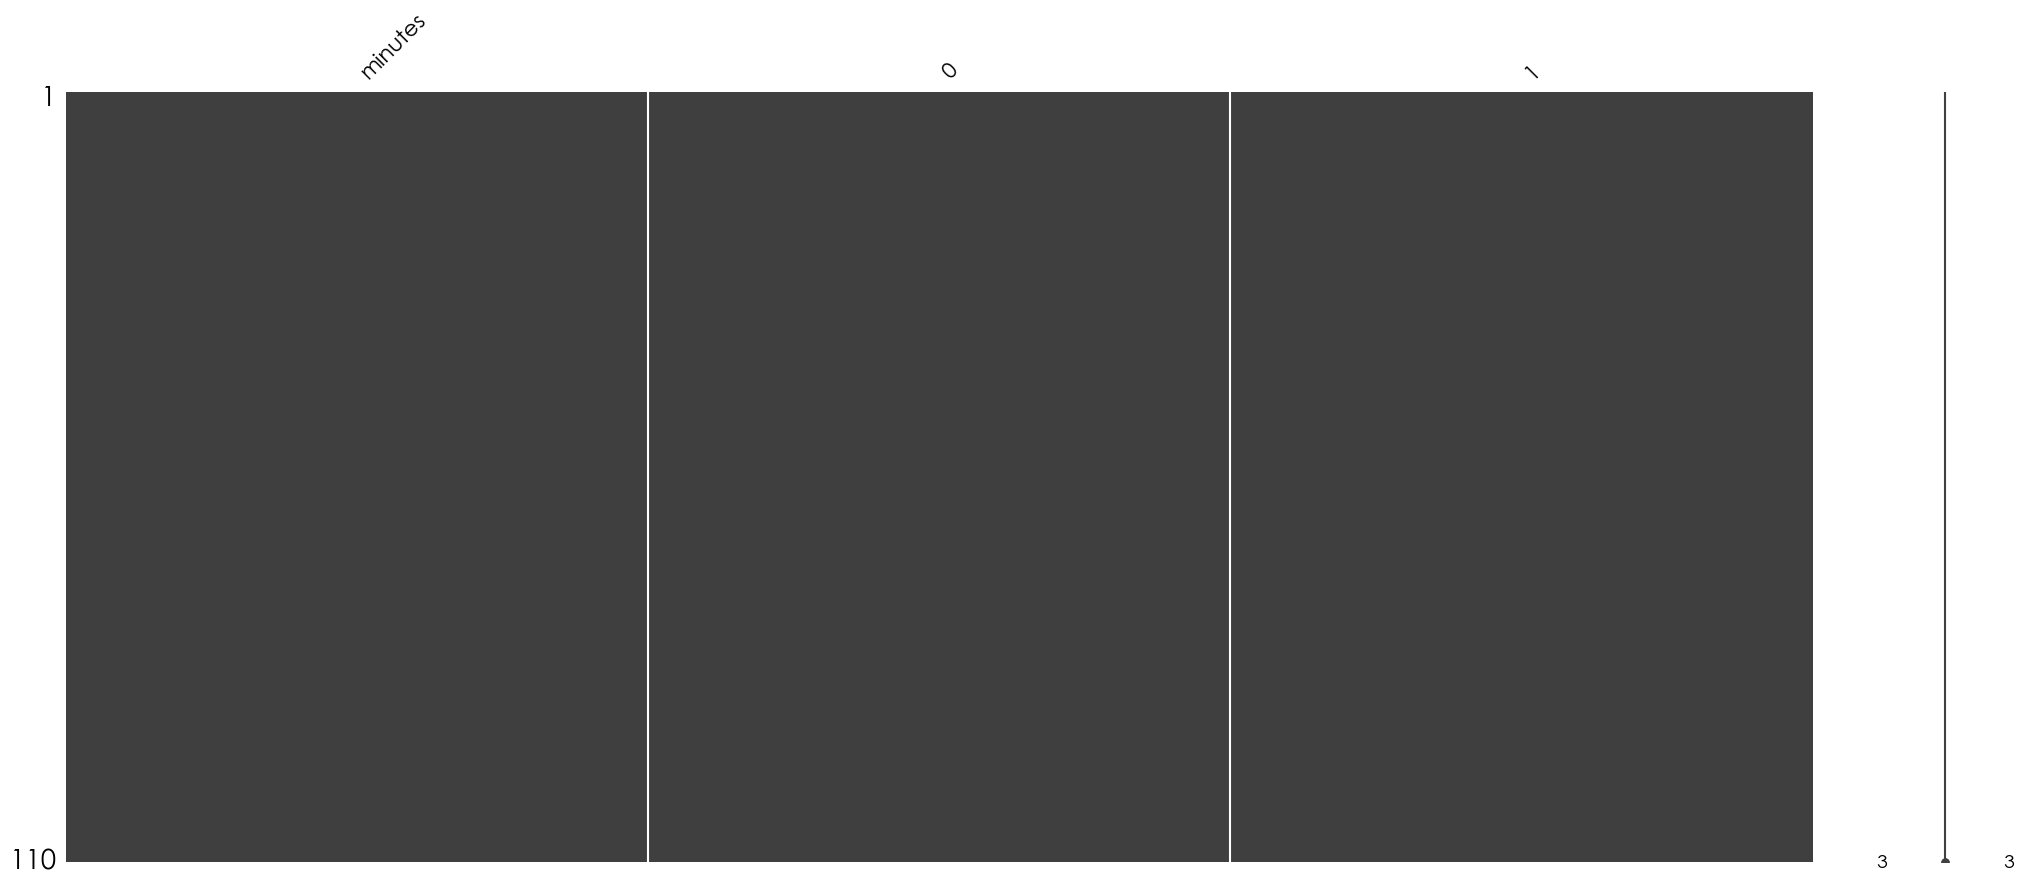

In [27]:
dic_temp = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd5_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd5_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd5_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd5_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({n_capas + j:c})

df_temp = pd.DataFrame(dic_temp)
df_temp.insert(loc= 0, column = 'minutes', value = minutes)
# df_temp[17] = df_temp[18] - 1
# df_temp[1] = df_temp[2] - 1
# df_temp[0] = df_temp[1] - 1
msno.matrix(df_temp)

In [28]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = f'temp_{frontera}_VALIDACION.bcc'
np.savetxt(path+'/'+name_file, df_temp.values, delimiter=' ', fmt = "%+15.7e")

# ERA 5

## Wave

In [15]:
# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             'mean_wave_direction', 'peak_wave_period', 'significant_height_of_combined_wind_waves_and_swell',
#         ],
#         'year': [ '2018',
#         ],
#         'month': [
#         '04', '05',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': 
#             '00:00/ 01:00/ 02:00/03:00/ 04:00/ 05:00/06:00/ 07:00/ 08:00/ 09:00/ 10:00/ 11:00/12:00/ 13:00/ 14:00/15:00/ 16:00/ 17:00/18:00/ 19:00/ 20:00/21:00/ 22:00/23:00'
#         ,
#         'area':[
#             '12.875','278','12.25','278.625',
#         ],
#         'grid':[
#             '0.125','0.125',
#         ],
#         'step' :"0"
#     },
#     'data_wave_MG_april_mayo_2018_.nc')

In [10]:
def read_rea5_wave_data(path, file_name):
    """
    Esta función lee los datos de los netcdf de las olas 
    - path: ruta donde se encuentra almacenado el archivo
    - file_name: nombre del archivo
    """
    data = Dataset(f'{path}\{file_name}','r')
    lat_wave = np.array(data.variables['latitude'][:]);
    lon_wave = np.array(data.variables['longitude'][:]);
    nctime_wave = np.array(data.variables['time'][:]);
    t_unit_wave = data.variables['time'].units;
    t_cal_wave = data.variables['time'].calendar;
    time_wave = num2date(nctime_wave,units=t_unit_wave,calendar=t_cal_wave);#Date time
    hs = np.array(data.variables['swh'][:]);
    tp = np.array(data.variables['pp1d'][:]);
    direc = np.array(data.variables['mwd'][:]);
    # Cambiar la zona horaria utc 0 a utc -5
    utc = pytz.utc
    col_zone = timezone('America/Bogota')
    # col_zone = timezone('GMT')
    time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time_wave])
    loc_co =np.array([i.astimezone(col_zone) for i in time2])
    time_wave = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

    dic_wave = {'time': time_wave, 'lon': lon_wave, 'lat':lat_wave ,'Hs': hs, 'Tp': tp, 'Direc': direc}
    # dic_wave = {'Hs': hs, 'Tp': tp, 'Direc': direc}

    return dic_wave

def TEPAR_files_swan(filename,lon, lat, Latitud, Longitud, time_wave, hs, tp, direc , date_ini, date_fin):
    """
    Función apra crear los archvios TPAR o condiciones de forontera del modelo swan
    --------------------------------------------------------------------------------------------------------
    Input:
    ------
    - filename: Nombre del archivo
    - Lon: Coordenada longitudinal del punto de interés
    - Lat: Coordenada latitudinal del punto de interés
    - Latitud: Serie de coordenadas latitudinales
    - Longitud: Serie de coordenadas longitudinales
    - date_ini: fecha inicial de la serie de datos
    - date_fin: Fecha final de la serie de datos
    """

    in_lat = np.where((Latitud == lat))[0]
    in_lon = np.where((Longitud == lon))[0]
    ind_ini_fin = np.where((time_wave==date_ini)|(time_wave==date_fin))[0]
    
    time_d3d_wave = time_wave[ind_ini_fin[0]:ind_ini_fin[1]]
    str_time_wave =[time_d3d_wave[i].strftime("%Y%m%d.%H%M") for i in range( len(time_d3d_wave))]
    Hs = hs[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Hs = [Hs[i][0] for i in range(len(Hs))]
    Tp = tp[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Tp = [Tp[i][0] for i in range(len(Tp))]
    Direc = direc[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Direc = [Direc[i][0] for i in range(len(Direc))]
    Des_direc = list(np.ones(shape=len(Direc))*40)
    Dir_Param = {'Time':str_time_wave, 'Hs': Hs, 'Tp': Tp, 'Direc': Direc, 'Des_Dirc': Des_direc}
    df_data = pd.DataFrame(data = Dir_Param)
    with open (filename+'_validacion.bnd', "w") as f:
        f.write("TPAR \n")
        np.savetxt(f,df_data,fmt =('%s  %7.9f  %8.9f  %9.9f  %5.1f'))
    return df_data

In [17]:
path = 'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS'
file_name = 'data_wave_MG_april_mayo_2018_.nc'
dic_wave = read_rea5_wave_data(path = path, file_name = file_name)
print(dic_wave.keys())

# -------------------Input-----------------------------------------
date_ini = datetime.datetime(2018,4,20,0) # Parámetro a variar
date_fin = datetime.datetime(2018,5,11,0) # Parámetro a variar
ind_ini_fin = np.where((dic_wave['time']==date_ini)|(dic_wave['time']==date_fin))[0]
time_d3d_wave = dic_wave['time'][ind_ini_fin[0]:ind_ini_fin[1]]
print(ind_ini_fin)
print(time_d3d_wave.shape)

dict_keys(['time', 'lon', 'lat', 'Hs', 'Tp', 'Direc'])
[461 965]
(504,)


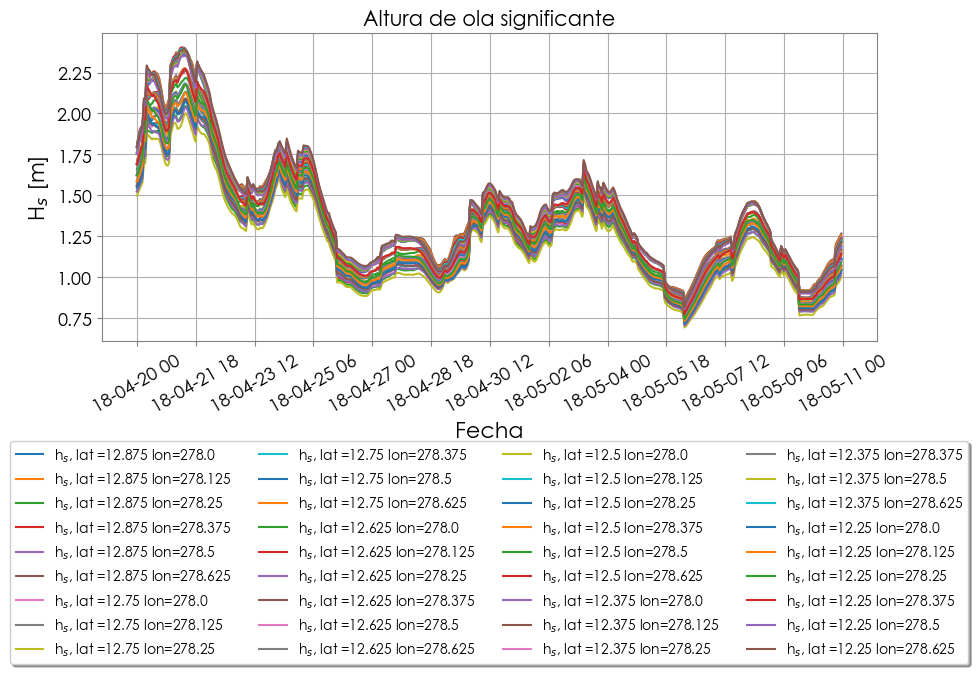

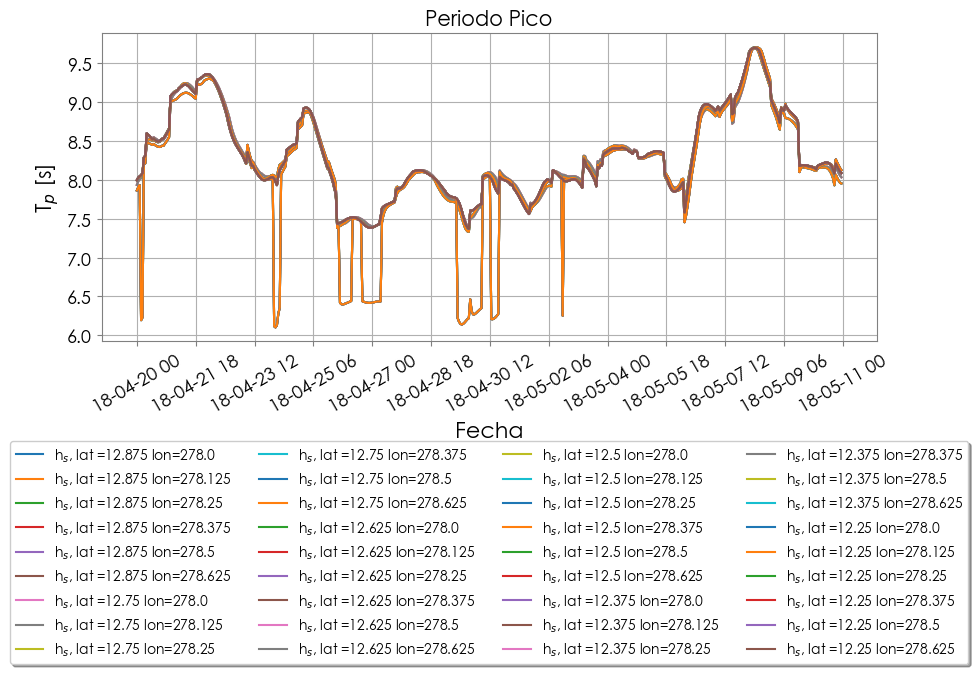

In [19]:
#Grafica de las alturas de ola significante 
hourticks = ((time_d3d_wave[-1]-time_d3d_wave[0]).days*24 +(time_d3d_wave[-1]-time_d3d_wave[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wave[0] + datetime.timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(10,4))
for i in range(len(dic_wave['lat'])):
    for j in range(len(dic_wave['lon'])):
        ax.plot(time_d3d_wave, dic_wave['Hs'][ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'h$_s$, lat ='+str(dic_wave['lat'][i])+ ' lon='+str(dic_wave['lon'][j]))
#         ax.plot(time_d3d_wave, v10_wave[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'v$_{10}$, lat ='+str(lat_wave[i])+ ' lon='+str(lon_wave[j]))
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,)
ax.set_ylabel ('H$_{s}$ [m]',size=16,)
fig_params(ax)
ax.set_title('Altura de ola significante',size = 15,)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10)
plt.xticks(rotation=30)
ax.grid(True)




#Grafica de las alturas de ola significante 
hourticks = ((time_d3d_wave[-1]-time_d3d_wave[0]).days*24 +(time_d3d_wave[-1]-time_d3d_wave[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wave[0] + datetime.timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(10,4))
for i in range(len(dic_wave['lat'])):
    for j in range(len(dic_wave['lon'])):
        ax.plot(time_d3d_wave, dic_wave['Tp'][ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'h$_s$, lat ='+str(dic_wave['lat'][i])+ ' lon='+str(dic_wave['lon'][j]))
#         ax.plot(time_d3d_wave, v10_wave[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'v$_{10}$, lat ='+str(lat_wave[i])+ ' lon='+str(lon_wave[j]))
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,)
ax.set_ylabel ('T$_{p}$ [s]',size=16,)
fig_params(ax)
ax.set_title('Periodo Pico',size = 15,)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10)
plt.xticks(rotation=30)
ax.grid(True)

In [20]:
# Note:
Boundary = 'Norte'
longitudes = [278.125,278.250, 278.375, 278.5]
lat = 12.750
for i in range (len(longitudes)):
    df_data = TEPAR_files_swan(filename = Boundary + str(i+1),
                     lon = longitudes[i], lat = lat , Latitud = dic_wave['lat'], 
                     Longitud = dic_wave['lon'], time_wave = dic_wave['time'], hs = dic_wave['Hs'], 
                     tp = dic_wave['Tp'], direc = dic_wave['Direc'] , date_ini = date_ini, date_fin = date_fin)
    

# Sur:
Boundary = 'Sur'
longitudes = [278.125,278.250, 278.375, 278.5]
lat = 12.375
for i in range (len(longitudes)):
    df_data = TEPAR_files_swan(filename = Boundary + str(i+1),
                     lon = longitudes[i], lat = lat , Latitud = dic_wave['lat'], 
                     Longitud = dic_wave['lon'], time_wave = dic_wave['time'], hs = dic_wave['Hs'], 
                     tp = dic_wave['Tp'], direc = dic_wave['Direc'] , date_ini = date_ini, date_fin = date_fin)
    

# Oeste:
Boundary = 'Oeste'
latitudes = [12.375, 12.5, 12.625, 12.750]
lon = 278.5
for i in range (len(latitudes)):
    df_data = TEPAR_files_swan(filename = Boundary + str(i+1),
                    lon = lon, lat = latitudes[i] , Latitud = dic_wave['lat'], 
                    Longitud = dic_wave['lon'], time_wave = dic_wave['time'], hs = dic_wave['Hs'], 
                    tp = dic_wave['Tp'], direc = dic_wave['Direc'] , date_ini = date_ini, date_fin = date_fin)


# Este:
Boundary = 'Este'
latitudes = [12.375, 12.5, 12.625, 12.750]
lon = 278.125
for i in range (len(latitudes)):
    df_data = TEPAR_files_swan(filename = Boundary + str(i+1),
                lon = lon, lat = latitudes[i] , Latitud = dic_wave['lat'], 
                Longitud = dic_wave['lon'], time_wave = dic_wave['time'], hs = dic_wave['Hs'], 
                tp = dic_wave['Tp'], direc = dic_wave['Direc'] , date_ini = date_ini, date_fin = date_fin)

## Wind

In [44]:
# # DESCARGAR DATOS DE VIENTOS DE ERA5
# c = cdsapi.Client()
# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             '10m_u_component_of_wind', '10m_v_component_of_wind',
#         ],
#         'year': [
#              '2018',
#         ],
#         'month': [
            
#             '04', '05', 
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area':[
#             '12.875','278','12.25','278.625',
#         ],
#         'grid':[
#             '0.125','0.125',
#         ],
#     },
#     'data_wind_april_may_2018_125.nc')

2023-04-20 16:28:31,732 INFO Welcome to the CDS
2023-04-20 16:28:31,732 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-04-20 16:28:32,005 INFO Request is queued
2023-04-20 16:28:33,210 INFO Request is running
2023-04-20 16:30:27,426 INFO Request is completed
2023-04-20 16:30:27,426 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.mars.internal-1682026215.73695-24187-11-abec2b51-ebf8-4d6d-9c36-d8c166ba4f09.nc to data_wind_april_may_2018_125.nc (212.9K)
2023-04-20 16:30:29,266 INFO Download rate 115.7K/s


Result(content_length=218056,content_type=application/x-netcdf,location=https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.mars.internal-1682026215.73695-24187-11-abec2b51-ebf8-4d6d-9c36-d8c166ba4f09.nc)

In [21]:
def read_wind_era5(path, file_name):
    """Esta función lee los datos del archivo NETCdf de vientos
    -----------------------------------------------------------
    Input:
    ------
    - path: ruta del archivo
    - file_name: nombre del archivo
    """
    data = Dataset(f'{path}\{file_name}','r')
    lat = np.array(data.variables['latitude'][:])
    lon = np.array(data.variables['longitude'][:])
    nctime = np.array(data.variables['time'][:])
    t_unit = data.variables['time'].units
    t_cal = data.variables['time'].calendar
    time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
    u10 = np.array(data.variables['u10'][:])
    v10 = np.array(data.variables['v10'][:])
    utc = pytz.utc
    col_zone = timezone('America/Bogota')
    # col_zone = timezone('GMT')
    time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
    loc_co =np.array([i.astimezone(col_zone) for i in time2])
    time = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
    dic_wind = {'time': time, 'lat': lat, 'lon':lon, 'u10': u10, 'v10':v10}
    return dic_wind

In [22]:
path = 'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS'
file_name = 'data_wind_april_may_2018_125.nc'
dic_wind = read_wind_era5(path = path, file_name = file_name)


In [23]:
plot_cells_data_base (lon = dic_wind['lon'] , lat = dic_wind['lat'], plot_dfbat=False, df_bat= None)

NameError: name 'plot_cells_data_base' is not defined

### Wind for swan 

In [24]:
def file_wind_swan (date_ini:datetime.datetime, date_fin: datetime.datetime, dic_wind:dict, file_output:str):
    """Función para generar la malla de vientos para el modelo SWAN

    Parameters
    ----------
    date_ini : datetime.datetime
        Fecha incial de modelación
    date_fin : datetime.datetime
        Fecha final de modelación
    dic_wind : dict
        Diccionario con la información del viento
    file_output: str
        Nombre del archvio de salida
    """
    in_dateini= np.where(dic_wind['time']==date_ini)[0][0]
    in_datefin = np.where(dic_wind['time']==date_fin)[0][0]
    data_u_split = dic_wind['u10'][in_dateini:in_datefin+1,:,:]
    data_v_split = dic_wind['v10'][in_dateini:in_datefin+1,:,:]
    time_split = dic_wind['time'][in_dateini:in_datefin+1]

    #Se hace el recorte del vector
    q1=np.where(np.asarray(time_split[:])==time_split[0])[0]
    q2=np.where(np.asarray(time_split[:])==time_split[-1])[0]
    with open (f"{file_output}.wnd",'w') as f:# Aquí se crea el archivo.txt
        for i in range(q1[0],q2[0]):
            f.write("%s\n" % time_split[i].strftime("%Y%m%d %H%M%S"))
            np.savetxt(f,data_u_split[i,:,:])#,fmt='%10.4f')
            np.savetxt(f,data_v_split[i,:,:])#,fmt='%10.4f')

In [25]:
date_ini = datetime.datetime(2018,4,20,0) # Parámetro a variar
date_fin = datetime.datetime(2018,5,11,0) # Parámetro a variar
file_wind_swan (date_ini = date_ini, date_fin = date_fin, dic_wind = dic_wind, file_output = 'wind_grid_april20_may5')

### Wind for Delft3D

In [78]:
def wind_for_d3d(date_ini:datetime.datetime, date_fin: datetime.datetime, dic_wind:dict, variable:str, file_output:str, localzone: int):
    """Esta función genera los archivos de entrada del modelo Delft3D de la componente de vientos

    Parameters
    ----------
    date_ini : datetime.datetime
        Fecha incial de modelación
    date_fin : datetime.datetime
        Fecha final de modelación
    dic_wind : dict
        Diccionario de las variables del viento
    variable : str
        Variable para generar el archivo ('u10', 'v10', 'pressure')
    file_output : str
        Nombre del archivo
    localzone: int
        Zona horaria local con respecto a Greenwich
    """
    in_dateini= np.where(dic_wind['time']==date_ini)[0][0]
    in_datefin = np.where(dic_wind['time']==date_fin)[0][0]
    data_u_split = dic_wind['u10'][in_dateini:in_datefin+1,:,:]
    data_v_split = dic_wind['v10'][in_dateini:in_datefin+1,:,:]
    time_split = dic_wind['time'][in_dateini:in_datefin+1]
    minutes = np.array([((time_split[i] - time_split[0]).days*1440)+((time_split[i] - time_split[0]).seconds/60) for i in range (0,len(time_split))])

    q1=np.where(np.asarray(time_split[:])==time_split[0])[0]
    q2=np.where(np.asarray(time_split[:])==time_split[-1])[0]

    if variable == 'u10': 
        with open (f"{file_output}.amu",'w') as f:# Aquí se crea el archivo.txt
            for i in range(q1[0],q2[0]):
                f.write("Time = %5.1f" % minutes[i] + " minutes since " + "%s" % time_split[0].strftime("%Y-%m-%d %H:%M:%S") + f" -0{localzone}:00 \n")
                np.savetxt(f,data_u_split[i,:,:][::-1])
    
    elif variable == 'v10': 
        with open (f"{file_output}.amv",'w') as f:# Aquí se crea el archivo.txt
            for i in range(q1[0],q2[0]):
                f.write("Time = %5.1f" % minutes[i] + " minutes since " + "%s" % time_split[0].strftime("%Y-%m-%d %H:%M:%S") + f" -0{localzone}:00 \n")
                np.savetxt(f,data_v_split[i,:,:][::-1])

    elif variable == 'pressure':
        air_prees = np.ones(shape = data_u_split.shape)*101300.0
        with open (f"{file_output}.amp",'w') as f:# Aquí se crea el archivo.txt
            for i in range(q1[0],q2[0]):
                f.write("Time = %5.1f" % minutes[i] + " minutes since " + "%s" % time_split[0].strftime("%Y-%m-%d %H:%M:%S") + f" -0{localzone}:00 \n")
                np.savetxt(f,air_prees[i,:,:][::-1])
                

In [79]:
date_ini = datetime.datetime(2018,5,1,7) # Parámetro a variar
date_fin = datetime.datetime(2018,5,10,10) # Parámetro a variar
wind_for_d3d(date_ini = date_ini, date_fin = date_fin , 
             dic_wind = dic_wind, variable = 'u10', 
             file_output = 'ERA5_x_wind_VALIDACION', localzone = 5)

wind_for_d3d(date_ini = date_ini, date_fin = date_fin , 
             dic_wind = dic_wind, variable = 'v10', 
             file_output = 'ERA5_y_wind_VALIDACION', localzone = 5)


wind_for_d3d(date_ini = date_ini, date_fin = date_fin , 
             dic_wind = dic_wind, variable = 'pressure', 
             file_output = 'ERA5_air_press_wind_VALIDACION', localzone = 5)